In [8]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

import matplotlib.pyplot as plt

from planning_utils import a_star, heuristic, create_grid, prune_path, create_grid_and_edges, a_starGraph, GetGraph, closest_point
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [9]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [10]:
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [11]:
grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

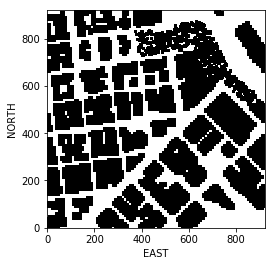

In [12]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')


plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

In [13]:
with open('colliders.csv', "r") as f:
    firstline = f.readline().split(',')

lat0 = float(firstline[0].split()[1])
lon0 = float(firstline[1].split()[1])

print(lat0)
print(lon0)

37.79248
-122.39745


In [15]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < self.get_waypoint_transition_threshold():
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()
                        
    def get_waypoint_transition_threshold(self):
        velocity = np.linalg.norm(self.local_velocity[0:2])
        print('velocity={}'.format(velocity))
        return 3.0

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE
        
        #waypoints = [[0, 0, 5, 0], [0, 20, 5, 0], [70, 90, 5, 0], [70, 110, 5, 0], [50, 130, 5, 0], [50, 140, 5, 0], [-51, 241, 5, 0], [-51, 242, 5, 0], [-52, 243, 5, 0], [-52, 244, 5, 0], [-53, 245, 5, 0], [-53, 246, 5, 0], [-54, 247, 5, 0], [-54, 248, 5, 0], [-55, 249, 5, 0], [-55, 250, 5, 0], [-56, 251, 5, 0], [-56, 253, 5, 0], [-57, 254, 5, 0], [-57, 255, 5, 0], [-58, 256, 5, 0], [-58, 257, 5, 0], [-59, 258, 5, 0], [-59, 259, 5, 0], [-60, 260, 5, 0], [-60, 261, 5, 0], [-61, 262, 5, 0], [-61, 264, 5, 0], [-62, 265, 5, 0], [-62, 266, 5, 0], [-63, 267, 5, 0], [-63, 268, 5, 0], [-64, 269, 5, 0], [-64, 270, 5, 0], [-65, 271, 5, 0], [-65, 272, 5, 0], [-66, 273, 5, 0], [-66, 274, 5, 0]]
        waypoints = [[0, 0, 5, 0], [-1, 0, 5, 0], [-1, 0, 5, 0], [-16, 15, 5, 0], [-34, 27, 5, 0], [-38, 33, 5, 0], [-44, 37, 5, 0], [-48, 43, 5, 0], [-54, 47, 5, 0], [-58, 53, 5, 0], [-70, 61, 5, 0], [-86, 65, 5, 0], [-97, 65, 5, 0], [-101, 70, 5, 0], [-106, 75, 5, 0], [-106, 105, 5, 0], [-108, 118, 5, 0], [-112, 122, 5, 0], [-117, 124, 5, 0], [-129, 132, 5, 0], [-133, 138, 5, 0], [-139, 142, 5, 0], [-143, 148, 5, 0], [-149, 152, 5, 0], [-157, 164, 5, 0], [-162, 175, 5, 0], [-168, 185, 5, 0], [-156, 205, 5, 0], [-146, 215, 5, 0], [-136, 225, 5, 0], [-136, 225, 5, 0], [-96, 265, 5, 0], [-96, 265, 5, 0], [-86, 265, 5, 0], [-86, 265, 5, 0], [-86, 265, 5, 0]]
        self.waypoints = waypoints
        print(self.waypoints)
        self.send_waypoints()
        return
        
        # TODO: read lat0, lon0 from colliders into floating point values
        with open('colliders.csv', "r") as f:
            firstline = f.readline().split(',')

        lat0 = float(firstline[0].split()[1])
        lon0 = float(firstline[1].split()[1])
        
        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(lon0, lat0, 0)

        # TODO: retrieve current global position
        global_position = self.global_position
 
        # TODO: convert to current local position using global_to_local()        
        local_position = global_to_local(global_position, self.global_home)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        
        # Voronoi option
        gridVoronoy, edges = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        G = GetGraph(edges)
        print('Graph edges:{0} nodes:{1}'.format(len(G.edges), len(G.nodes)))
        
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid        
        grid_goal = (250,720)# (-north_offset + 10, -east_offset + 10)
                
        
        # TODO: adapt to set goal as latitude / longitude position and convert
        local_position = global_to_local([-122.38925748, 37.79469147, 0.0], self.global_home)
        grid_goal = (int(local_position[0]), int(local_position[1]))
        #global_goal = local_to_global(grid_goal, self.global_home)
        #print('Goal:{0}', global_goal)
        

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        
        print('Local Start and Goal: ', grid_start, grid_goal)
#        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

#       path = prune_path(path)
        
        # Convert path to waypoints
#        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
#        self.waypoints = waypoints
#        print(self.waypoints)
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
#        self.send_waypoints()
#        return
        
#        fig = plt.figure()
#        plt.imshow(grid, cmap='Greys', origin='lower')
#        pp = np.array(path)
#        plt.plot(pp[:, 1], pp[:, 0], 'r')
#        plt.xlabel('EAST')
#        plt.ylabel('NORTH')
#        plt.show()
        
        
        start_ne = grid_start
        goal_ne = grid_goal
        start_ne_g = closest_point(G, grid_start)
        goal_ne_g = closest_point(G, grid_goal)
        
        path, cost = a_starGraph(G, heuristic, start_ne_g, goal_ne_g)
        
        start_ne_g = (int(start_ne_g[0]), int(start_ne_g[1]))
        goal_ne_g = (int(goal_ne_g[0]), int(goal_ne_g[1]))        
        
        print('start_ne={0}, start_ne_g={1}, goal_ne_g={2}, goal_ne={3}'.format(start_ne, start_ne_g, goal_ne_g, goal_ne))
        pathToBegin, _ = a_star(grid, heuristic, start_ne, start_ne_g)
        pathFromEnd, _ = a_star(grid, heuristic, goal_ne_g, goal_ne)

        newpath = pathToBegin + path + pathFromEnd
        
        newpath = prune_path(newpath)
        waypoints = [[int(p[0]) + north_offset, int(p[1]) + east_offset, TARGET_ALTITUDE, 0] for p in newpath]
        self.waypoints = waypoints
        print(self.waypoints)
        self.send_waypoints()
        
#        fig = plt.figure()
#        plt.imshow(grid, cmap='Greys', origin='lower')        
#        pp = np.array(newpath)
#        plt.plot(pp[:, 1], pp[:, 0], 'r')
#        plt.xlabel('EAST')
#        plt.ylabel('NORTH')
#        plt.show()

        #for e in edges:
        #    p1 = e[0]
        #    p2 = e[1]
        #    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

        #plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
        #for i in range(len(path)-1):
        #    p1 = path[i]
        #    p2 = path[i+1]
        #    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
        #plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')

        #plt.plot(start_ne[1], start_ne[0], 'gx')
        #plt.plot(goal_ne[1], goal_ne[0], 'gx')

        #plt.xlabel('EAST', fontsize=20)
        #plt.ylabel('NORTH', fontsize=20)
        #plt.show()
        

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
drone = MotionPlanning(conn)
time.sleep(1)

drone.start()

Logs\TLog.txt
Logs\NavLog.txt
starting connection
arming transition
Searching for a path ...
[[0, 0, 5, 0], [-1, 0, 5, 0], [-1, 0, 5, 0], [-16, 15, 5, 0], [-34, 27, 5, 0], [-38, 33, 5, 0], [-44, 37, 5, 0], [-48, 43, 5, 0], [-54, 47, 5, 0], [-58, 53, 5, 0], [-70, 61, 5, 0], [-86, 65, 5, 0], [-97, 65, 5, 0], [-101, 70, 5, 0], [-106, 75, 5, 0], [-106, 105, 5, 0], [-108, 118, 5, 0], [-112, 122, 5, 0], [-117, 124, 5, 0], [-129, 132, 5, 0], [-133, 138, 5, 0], [-139, 142, 5, 0], [-143, 148, 5, 0], [-149, 152, 5, 0], [-157, 164, 5, 0], [-162, 175, 5, 0], [-168, 185, 5, 0], [-156, 205, 5, 0], [-146, 215, 5, 0], [-136, 225, 5, 0], [-136, 225, 5, 0], [-96, 265, 5, 0], [-96, 265, 5, 0], [-86, 265, 5, 0], [-86, 265, 5, 0], [-86, 265, 5, 0]]
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
velocity=0.0
waypoint transition
target position [-1, 0, 5, 0]
velocity=0.17029386365926402
waypoint transition
target position [-1, 0, 5, 0]
velocity=0.941328

velocity=3.816935943921512
velocity=2.3803361107205006
velocity=1.132651755836718
velocity=0.7596051605933177
landing transition
disarm transition
manual transition
Closing connection ...


In [8]:
print(np.sqrt(2))

1.4142135623730951


In [9]:
from bresenham import bresenham

In [10]:
from scipy.spatial import Voronoi

In [11]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
nx.__version__

'2.1'